## Assignment: Object detection
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Put into practice acquired knowledge to detect and recognize objects of interest within a satellite image.

To address this problem, you must choose one of the following options:
*	Implement a sliding window strategy to process the whole image, and then train a classifier that determines whether each window includes or not an object of interest. In this way, you can use previous image classification model to infer the object category.
*	Build a single-stage object detection model (e.g., YOLO, SSD, RetinaNet, etc.).
*	Build a two-stage object detection model (e.g., Faster R-CNN, R-FCN, etc.).

Follow the link below to download the detection data set “xview_detection”: [https://drive.upm.es/s/P7nEf3Bygns7tbM](https://drive.upm.es/s/P7nEf3Bygns7tbM)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-09-22 07:52:50.248064: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 07:52:50.701721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 07:52:50.701808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 07:52:50.801276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'Small car', 1: 'Bus', 2: 'Truck', 3: 'Building'}

In [4]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('../PROJECT/xview_detection/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a detector to deal with the “xview_detection” perception task.

In [5]:
import json

# Load database
json_file = '../PROJECT/xview_detection/xview_det_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img in json_data['images'].values():
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    for json_ann in [elem for elem in json_data['annotations'].values() if elem['image_id'] == json_img['image_id']]:
        obj = GenericObject()
        obj.id = json_ann['image_id']
        obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
        obj.category = json_ann['category_id']
        counts[obj.category] += 1
        image.add_object(obj)
    anns.append(image)
print(counts)

{'Small car': 188300, 'Bus': 6269, 'Truck': 10600, 'Building': 275943}


In [7]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 6845
Number of validation images: 761


In [8]:
# Load architecture
import keras_cv

print('Load model')
prediction_decoder = keras_cv.layers.NonMaxSuppression(bounding_box_format='xyxy', from_logits=False, confidence_threshold=0.2, iou_threshold=0.7)
model = keras_cv.models.YOLOV8Detector.from_preset(preset='yolo_v8_xs_backbone_coco', num_classes=len(categories), load_weights=True, bounding_box_format='xyxy', prediction_decoder=prediction_decoder)
model.summary()

Using TensorFlow backend
Load model


2025-09-22 07:58:12.826471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1277680   ['input_2[0][0]']             
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                                  

In [9]:
from tensorflow.keras.optimizers import SGD

# Learning rate is changed to 0.001
opt = SGD(learning_rate=1e-3, momentum=0.9, global_clipnorm=10.0)
model.compile(optimizer=opt, classification_loss='binary_crossentropy', box_loss='ciou', jit_compile=False)

In [10]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_loss', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [11]:
def image_generator(filename, tile, bboxes, categories):
    def load_sample(filepath):
        image = load_geoimage(filepath.numpy().decode('utf-8'))
        return tf.cast(image, tf.uint8)
    # Load image
    img = tf.squeeze(tf.py_function(func=load_sample, inp=[filename], Tout=[tf.uint8]), axis=0)  # tf.print(tf.shape(img)) -> [H, W, 3]
    img_roi = tf.image.pad_to_bounding_box(img, 0, 0, 640, 640)
    return {'images': tf.cast(img_roi, tf.float32), 'bounding_boxes': {'boxes': bboxes, 'classes': categories}}

def ragged_to_dense(inputs):
    from keras_cv import bounding_box
    return {'images': inputs['images'].to_tensor(), 'bounding_boxes': bounding_box.to_dense(inputs['bounding_boxes'], max_boxes=2000)}

def dict_to_tuple(inputs):
    return inputs['images'], inputs['bounding_boxes']

In [12]:
# Generate the list of objects from annotations
filenames_train, tiles_train, bboxes_train, categories_train = zip(*list(map(lambda img_ann: (img_ann.filename, list(img_ann.tile), list([list(obj_ann.bb) for obj_ann in img_ann.objects]), list([list(categories.keys())[list(categories.values()).index(obj_ann.category)] for obj_ann in img_ann.objects])), anns_train)))
filenames_valid, tiles_valid, bboxes_valid, categories_valid = zip(*list(map(lambda img_ann: (img_ann.filename, list(img_ann.tile), list([list(obj_ann.bb) for obj_ann in img_ann.objects]), list([list(categories.keys())[list(categories.values()).index(obj_ann.category)] for obj_ann in img_ann.objects])), anns_valid)))
ds_train = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_train, tf.string), tf.cast(tiles_train, tf.int32), tf.cast(tf.ragged.constant(bboxes_train), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_train), tf.float32).to_tensor()))
ds_valid = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_valid, tf.string), tf.cast(tiles_valid, tf.int32), tf.cast(tf.ragged.constant(bboxes_valid), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_valid), tf.float32).to_tensor()))
ds_train = ds_train.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE)
# Generators
batch_size = 4
ds_train = ds_train.shuffle(batch_size*5)
ds_train = ds_train.ragged_batch(batch_size=batch_size, drop_remainder=True)
ds_valid = ds_valid.ragged_batch(batch_size=batch_size, drop_remainder=True)
data_augmentation = tf.keras.Sequential(
    layers=[keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', bounding_box_format='xyxy'),
            keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format='xyxy'),
            keras_cv.layers.RandomColorDegeneration(factor=0.5)])
ds_train = ds_train.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
# Bounding box tensors need to be Dense instead of Ragged
ds_train = ds_train.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [13]:
import numpy as np

print('Training model')
epochs = 40
train_steps, valid_steps = len(ds_train), len(ds_valid)
h = model.fit(ds_train, steps_per_epoch=train_steps, validation_data=ds_valid, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmin(h.history['val_loss']))
best_value = np.min(h.history['val_loss'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_loss ' + str(best_value))

Training model
Epoch 1/40


2025-09-22 07:58:44.760092: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-09-22 07:58:55.006598: I external/local_xla/xla/service/service.cc:168] XLA service 0x14c9e4c87e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-22 07:58:55.006679: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
I0000 00:00:1758527935.265511    2849 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1711/1711 [==============================] - ETA: 0s - loss: 5.7019 - box_loss: 2.7120 - class_loss: 2.9899
Epoch 1: val_loss improved from inf to 2.85647, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1846s 1s/step - loss: 5.7019 - box_loss: 2.7120 - class_loss: 2.9899 - val_loss: 2.8565 - val_box_loss: 2.3741 - val_class_loss: 0.4824 - lr: 0.0010
Epoch 2/40
1711/1711 [==============================] - ETA: 0s - loss: 2.7896 - box_loss: 2.2959 - class_loss: 0.4937
Epoch 2: val_loss improved from 2.85647 to 2.74703, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1808s 1s/step - loss: 2.7896 - box_loss: 2.2959 - class_loss: 0.4937 - val_loss: 2.7470 - val_box_loss: 2.3089 - val_class_loss: 0.4381 - lr: 0.0010
Epoch 3/40
1711/1711 [==============================] - ETA: 0s - loss: 2.6765 - box_loss: 2.2209 - class_loss: 0.4556
Epoch 3: val_loss improved from 2.74703 to 2.72493, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1808s 1s/step - loss: 2.6765 - box_loss: 2.2209 - class_loss: 0.4556 - val_loss: 2.7249 - val_box_loss: 2.3068 - val_class_loss: 0.4181 - lr: 0.0010
Epoch 4/40
1711/1711 [==============================] - ETA: 0s - loss: 2.6152 - box_loss: 2.1772 - class_loss: 0.4380
Epoch 4: val_loss did not improve from 2.72493
1711/1711 [==============================] - 1806s 1s/step - loss: 2.6152 - box_loss: 2.1772 - class_loss: 0.4380 - val_loss: 2.7618 - val_box_loss: 2.3497 - val_class_loss: 0.4121 - lr: 0.0010
Epoch 5/40
1711/1711 [==============================] - ETA: 0s - loss: 2.5693 - box_loss: 2.1452 - class_loss: 0.4241
Epoch 5: val_loss improved from 2.72493 to 2.67520, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1787s 1s/step - loss: 2.5693 - box_loss: 2.1452 - class_loss: 0.4241 - val_loss: 2.6752 - val_box_loss: 2.2807 - val_class_loss: 0.3945 - lr: 0.0010
Epoch 6/40
1711/1711 [==============================] - ETA: 0s - loss: 2.5289 - box_loss: 2.1141 - class_loss: 0.4149
Epoch 6: val_loss improved from 2.67520 to 2.61815, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1776s 1s/step - loss: 2.5289 - box_loss: 2.1141 - class_loss: 0.4149 - val_loss: 2.6182 - val_box_loss: 2.2262 - val_class_loss: 0.3919 - lr: 0.0010
Epoch 7/40
1711/1711 [==============================] - ETA: 0s - loss: 2.5087 - box_loss: 2.1020 - class_loss: 0.4067
Epoch 7: val_loss did not improve from 2.61815
1711/1711 [==============================] - 1790s 1s/step - loss: 2.5087 - box_loss: 2.1020 - class_loss: 0.4067 - val_loss: 2.6359 - val_box_loss: 2.2459 - val_class_loss: 0.3900 - lr: 0.0010
Epoch 8/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4810 - box_loss: 2.0802 - class_loss: 0.4008
Epoch 8: val_loss improved from 2.61815 to 2.54459, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1786s 1s/step - loss: 2.4810 - box_loss: 2.0802 - class_loss: 0.4008 - val_loss: 2.5446 - val_box_loss: 2.1560 - val_class_loss: 0.3886 - lr: 0.0010
Epoch 9/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4619 - box_loss: 2.0654 - class_loss: 0.3965
Epoch 9: val_loss did not improve from 2.54459
1711/1711 [==============================] - 1816s 1s/step - loss: 2.4619 - box_loss: 2.0654 - class_loss: 0.3965 - val_loss: 2.6307 - val_box_loss: 2.2377 - val_class_loss: 0.3930 - lr: 0.0010
Epoch 10/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4435 - box_loss: 2.0514 - class_loss: 0.3921
Epoch 10: val_loss did not improve from 2.54459
1711/1711 [==============================] - 1803s 1s/step - loss: 2.4435 - box_loss: 2.0514 - class_loss: 0.3921 - val_loss: 2.5656 - val_box_loss: 2.1791 - val_class_loss: 0.3865 - lr: 0.0010
Epoch 11/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4344 - bo

/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1793s 1s/step - loss: 2.4344 - box_loss: 2.0456 - class_loss: 0.3888 - val_loss: 2.5329 - val_box_loss: 2.1538 - val_class_loss: 0.3791 - lr: 0.0010
Epoch 12/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4140 - box_loss: 2.0309 - class_loss: 0.3830
Epoch 12: val_loss did not improve from 2.53285
1711/1711 [==============================] - 1814s 1s/step - loss: 2.4140 - box_loss: 2.0309 - class_loss: 0.3830 - val_loss: 2.5511 - val_box_loss: 2.1767 - val_class_loss: 0.3744 - lr: 0.0010
Epoch 13/40
1711/1711 [==============================] - ETA: 0s - loss: 2.4035 - box_loss: 2.0220 - class_loss: 0.3814
Epoch 13: val_loss did not improve from 2.53285
1711/1711 [==============================] - 1816s 1s/step - loss: 2.4035 - box_loss: 2.0220 - class_loss: 0.3814 - val_loss: 2.5500 - val_box_loss: 2.1689 - val_class_loss: 0.3812 - lr: 0.0010
Epoch 14/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3948 - 

/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1808s 1s/step - loss: 2.3696 - box_loss: 1.9973 - class_loss: 0.3723 - val_loss: 2.5292 - val_box_loss: 2.1564 - val_class_loss: 0.3728 - lr: 0.0010
Epoch 18/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3565 - box_loss: 1.9877 - class_loss: 0.3689
Epoch 18: val_loss improved from 2.52922 to 2.52118, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1817s 1s/step - loss: 2.3565 - box_loss: 1.9877 - class_loss: 0.3689 - val_loss: 2.5212 - val_box_loss: 2.1505 - val_class_loss: 0.3706 - lr: 0.0010
Epoch 19/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3470 - box_loss: 1.9794 - class_loss: 0.3676
Epoch 19: val_loss did not improve from 2.52118
1711/1711 [==============================] - 1811s 1s/step - loss: 2.3470 - box_loss: 1.9794 - class_loss: 0.3676 - val_loss: 2.5498 - val_box_loss: 2.1791 - val_class_loss: 0.3707 - lr: 0.0010
Epoch 20/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3381 - box_loss: 1.9718 - class_loss: 0.3662
Epoch 20: val_loss improved from 2.52118 to 2.49435, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1813s 1s/step - loss: 2.3381 - box_loss: 1.9718 - class_loss: 0.3662 - val_loss: 2.4944 - val_box_loss: 2.1278 - val_class_loss: 0.3666 - lr: 0.0010
Epoch 21/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3279 - box_loss: 1.9658 - class_loss: 0.3622
Epoch 21: val_loss did not improve from 2.49435
1711/1711 [==============================] - 1810s 1s/step - loss: 2.3279 - box_loss: 1.9658 - class_loss: 0.3622 - val_loss: 2.5248 - val_box_loss: 2.1558 - val_class_loss: 0.3690 - lr: 0.0010
Epoch 22/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3240 - box_loss: 1.9610 - class_loss: 0.3629
Epoch 22: val_loss did not improve from 2.49435
1711/1711 [==============================] - 1806s 1s/step - loss: 2.3240 - box_loss: 1.9610 - class_loss: 0.3629 - val_loss: 2.5570 - val_box_loss: 2.1896 - val_class_loss: 0.3674 - lr: 0.0010
Epoch 23/40
1711/1711 [==============================] - ETA: 0s - loss: 2.3218 - 

/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1832s 1s/step - loss: 2.2813 - box_loss: 1.9293 - class_loss: 0.3520 - val_loss: 2.4797 - val_box_loss: 2.1177 - val_class_loss: 0.3620 - lr: 0.0010
Epoch 30/40
1711/1711 [==============================] - ETA: 0s - loss: 2.2814 - box_loss: 1.9295 - class_loss: 0.3519
Epoch 30: val_loss improved from 2.47967 to 2.45156, saving model to model.keras


/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1711/1711 [==============================] - 1834s 1s/step - loss: 2.2814 - box_loss: 1.9295 - class_loss: 0.3519 - val_loss: 2.4516 - val_box_loss: 2.0874 - val_class_loss: 0.3642 - lr: 0.0010
Epoch 31/40
1711/1711 [==============================] - ETA: 0s - loss: 2.2737 - box_loss: 1.9236 - class_loss: 0.3501
Epoch 31: val_loss did not improve from 2.45156
1711/1711 [==============================] - 1828s 1s/step - loss: 2.2737 - box_loss: 1.9236 - class_loss: 0.3501 - val_loss: 2.4765 - val_box_loss: 2.1146 - val_class_loss: 0.3619 - lr: 0.0010
Epoch 32/40
1711/1711 [==============================] - ETA: 0s - loss: 2.2710 - box_loss: 1.9205 - class_loss: 0.3505
Epoch 32: val_loss did not improve from 2.45156
1711/1711 [==============================] - 1823s 1s/step - loss: 2.2710 - box_loss: 1.9205 - class_loss: 0.3505 - val_loss: 2.5631 - val_box_loss: 2.1939 - val_class_loss: 0.3692 - lr: 0.0010
Epoch 33/40
1711/1711 [==============================] - ETA: 0s - loss: 2.2680 - 

#### Validation
Compute validation metrics.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
%matplotlib inline

def area_intersection(boxes, box):
    xmin = np.maximum(np.min(boxes[:, 0::2], axis=1), np.min(box[0::2]))
    ymin = np.maximum(np.min(boxes[:, 1::2], axis=1), np.min(box[1::2]))
    xmax = np.minimum(np.max(boxes[:, 0::2], axis=1), np.max(box[0::2]))
    ymax = np.minimum(np.max(boxes[:, 1::2], axis=1), np.max(box[1::2]))
    w = np.maximum(xmax - xmin + 1.0, 0.0)
    h = np.maximum(ymax - ymin + 1.0, 0.0)
    return w * h

def area_union(boxes, box):
    area_anns = (np.max(box[0::2])-np.min(box[0::2])+1.0) * (np.max(box[1::2])-np.min(box[1::2])+1.0)
    area_pred = (np.max(boxes[:, 0::2], axis=1)-np.min(boxes[:, 0::2], axis=1)+1.0) * (np.max(boxes[:, 1::2], axis=1)-np.min(boxes[:, 1::2], axis=1)+1.0)
    return area_anns + area_pred - area_intersection(boxes, box)

def calc_iou(boxes, box):
    iou = area_intersection(boxes, box) / area_union(boxes, box)
    max_value = np.max(iou)
    max_index = np.argmax(iou)
    return max_value, max_index

def calc_ap(rec, prec):
    # First append sentinel values at the end
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    # Compute the precision envelope
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    # To calculate area under PR curve, look for points where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]
    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])
    return ap

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

def draw_precision_recall(precisions, recalls, categories):
    # Draw precision-recall curves for each category
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    plt.axis([0, 1, 0, 1])
    c_dark = list(filter(lambda x: x.startswith('dark'), col.cnames.keys()))
    aps = []
    # Compare categories for a specific algorithm
    for idx in range(len(categories)):
        plt.plot(recalls[idx], precisions[idx], color=c_dark[idx], label=categories[idx], linewidth=4.0)
        aps.append(calc_ap(recalls[idx], precisions[idx]))
    handles, labels = ax.get_legend_handles_labels()
    labels = [str(val + ' [' + "{:.3f}".format(aps[idx]) + ']') for idx, val in enumerate(labels)]
    handles = [h for (ap, h) in sorted(zip(aps, handles), key=lambda x: x[0], reverse=True)]
    labels = [l for (ap, l) in sorted(zip(aps, labels), key=lambda x: x[0], reverse=True)]
    leg = plt.legend(handles, labels, loc='upper right')
    leg.set_zorder(100)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid("on", linestyle="--", linewidth=2.0)
    fig.tight_layout()
    plt.show()

In [15]:
import numpy as np
from tqdm import tqdm

model.load_weights('model.keras')
# Generate the list of objects from annotations
ds_valid = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_valid, tf.string), tf.cast(tiles_valid, tf.int32), tf.cast(tf.ragged.constant(bboxes_valid), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_valid), tf.float32).to_tensor()))
ds_valid = ds_valid.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE).cache()
ds_valid = ds_valid.batch(batch_size=1)
ds_valid = ds_valid.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# Process each tile sequentially
iterator = iter(ds_valid)
annotations, predictions = {}, {}
for ann in tqdm(anns_valid):
    # Save annotations
    annotations.setdefault(ann.filename, {})
    predictions.setdefault(ann.filename, {})
    for obj in ann.objects:
        annotations[ann.filename].setdefault(obj.category, {'bbox': []})
        annotations[ann.filename][obj.category]['bbox'].append(obj.bb)
    # Save prediction
    image, _ = next(iterator)
    y_pred = model.predict(image, verbose=0)
    for i in range(np.squeeze(y_pred['num_detections'])):
        obj = GenericObject()
        bbox = np.squeeze(y_pred['boxes'])[i]
        obj.bb = (bbox[0], bbox[1], bbox[2], bbox[3])
        obj.category = categories[np.squeeze(y_pred['classes'])[i]]
        obj.score = np.squeeze(y_pred['confidence'])[i]
        predictions[ann.filename].setdefault(obj.category, {'bbox': [], 'confidence': []})
        predictions[ann.filename][obj.category]['bbox'].append(obj.bb)
        predictions[ann.filename][obj.category]['confidence'].append(obj.score)  # sort detections by confidence

/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
100%|██████████| 761/761 [02:23<00:00,  5.29it/s]


In [16]:
threshold = 0.5
default_cls = 'BACKGROUND'
y_true, y_pred = [], []  # confusion matrix
tps, confidences = dict(), dict()  # draw precision-recall curves for each category
for cls in categories.values():
    # Compute TP, FP and FN for each image
    tps[cls], confidences[cls] = [], []
    for f in predictions:
        # Sort 'cls' predictions by confidence for each file
        pred_boxes, pred_confidences = [], []
        if cls in predictions[f].keys():
            for idx in range(len(predictions[f][cls]['bbox'])):
                pred_boxes.append(predictions[f][cls]['bbox'][idx])
                pred_confidences.append(predictions[f][cls]['confidence'][idx])
            sorted_ind = np.argsort(-np.array(pred_confidences))
            pred_boxes = np.array(pred_boxes)[sorted_ind, :]
        pred_boxes = np.array(pred_boxes).astype(float)
        # Define 'cls' annotations for each file
        anno_boxes = []
        if cls in annotations[f].keys():
            anno_boxes = annotations[f][cls]['bbox']
        anno_boxes = np.array(anno_boxes).astype(float)
        # Define horizontal or oriented bounding boxes
        anno_indices = list(range(len(anno_boxes)))
        # Compare a single prediction 'pred_box' with all annotations 'anno_boxes'
        for pred_idx, pred_box in enumerate(pred_boxes):
            # A prediction is correct if its IoU with the ground truth is above the threshold
            iou_value, ann_index = calc_iou(anno_boxes, pred_box) if len(anno_boxes) > 0 else (-1, -1)
            if iou_value > threshold and ann_index in anno_indices:
                # TP
                anno_indices.remove(int(ann_index))
                tps[cls] += [1.0]
                y_true += [cls]
            else:
                # FP
                tps[cls] += [0.0]
                y_true += [default_cls]
            y_pred += [cls]
            confidences[cls] += [pred_confidences[pred_idx]]
        # FN
        y_true += [cls] * len(anno_indices)
        y_pred += [default_cls] * len(anno_indices)
y_true, y_pred = np.array(y_true), np.array(y_pred)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Compute AP metric
precision_list, recall_list, ap_list = [], [], []
for cls in categories.values():
    sorted_ind = np.argsort(-np.array(confidences[cls]))
    tp = np.cumsum(np.array(tps[cls])[sorted_ind], dtype=float)
    recall = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(np.sum(y_true == cls), np.finfo(np.float64).eps)
    precision = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(list(range(1, np.sum(y_pred == cls)+1)), np.finfo(np.float64).eps)
    ap = calc_ap(recall, precision)
    print('> %s: Recall: %.3f%% Precision: %.3f%% AP: %.3f%%' % (cls, recall[-1]*100, precision[-1]*100, ap*100))
    precision_list.append(precision)
    recall_list.append(recall)
    ap_list.append(ap)
mean_ap = np.mean(ap_list)
print('mAccuracy: %.3f%%' % (accuracy_score(y_true, y_pred)*100))
print('mRecall: %.3f%%' % (recall_score(y_true, y_pred, average='macro', zero_division=1)*100))
print('mPrecision: %.3f%%' % (precision_score(y_true, y_pred, average='macro', zero_division=1)*100))
print('mAP: %.3f%%' % (mean_ap*100))

> Small car: Recall: 43.535% Precision: 57.917% AP: 32.940%
> Bus: Recall: 10.469% Precision: 32.683% AP: 4.655%
> Truck: Recall: 0.479% Precision: 41.667% AP: 0.363%
> Building: Recall: 50.851% Precision: 54.603% AP: 40.963%
mAccuracy: 33.921%
mRecall: 21.067%
mPrecision: 37.374%
mAP: 19.730%


Confusion matrix:
[[    0  5536   138     7 12141]
 [ 9882  7619     0     0     0]
 [  573     0    67     0     0]
 [ 1039     0     0     5     0]
 [14114     0     0     0 14603]]


/tmp/ipykernel_2792/2574756117.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


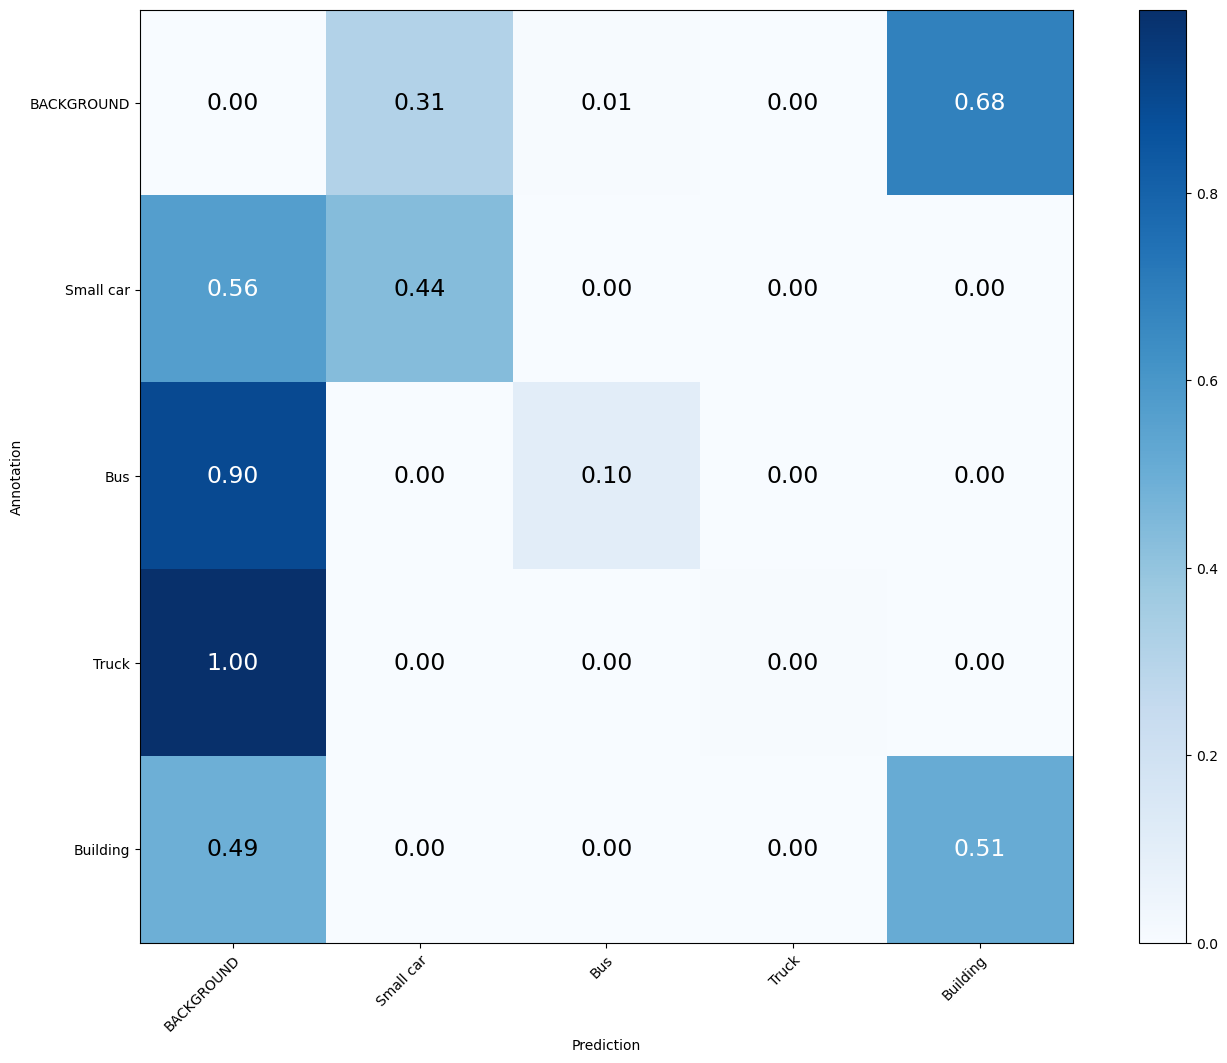

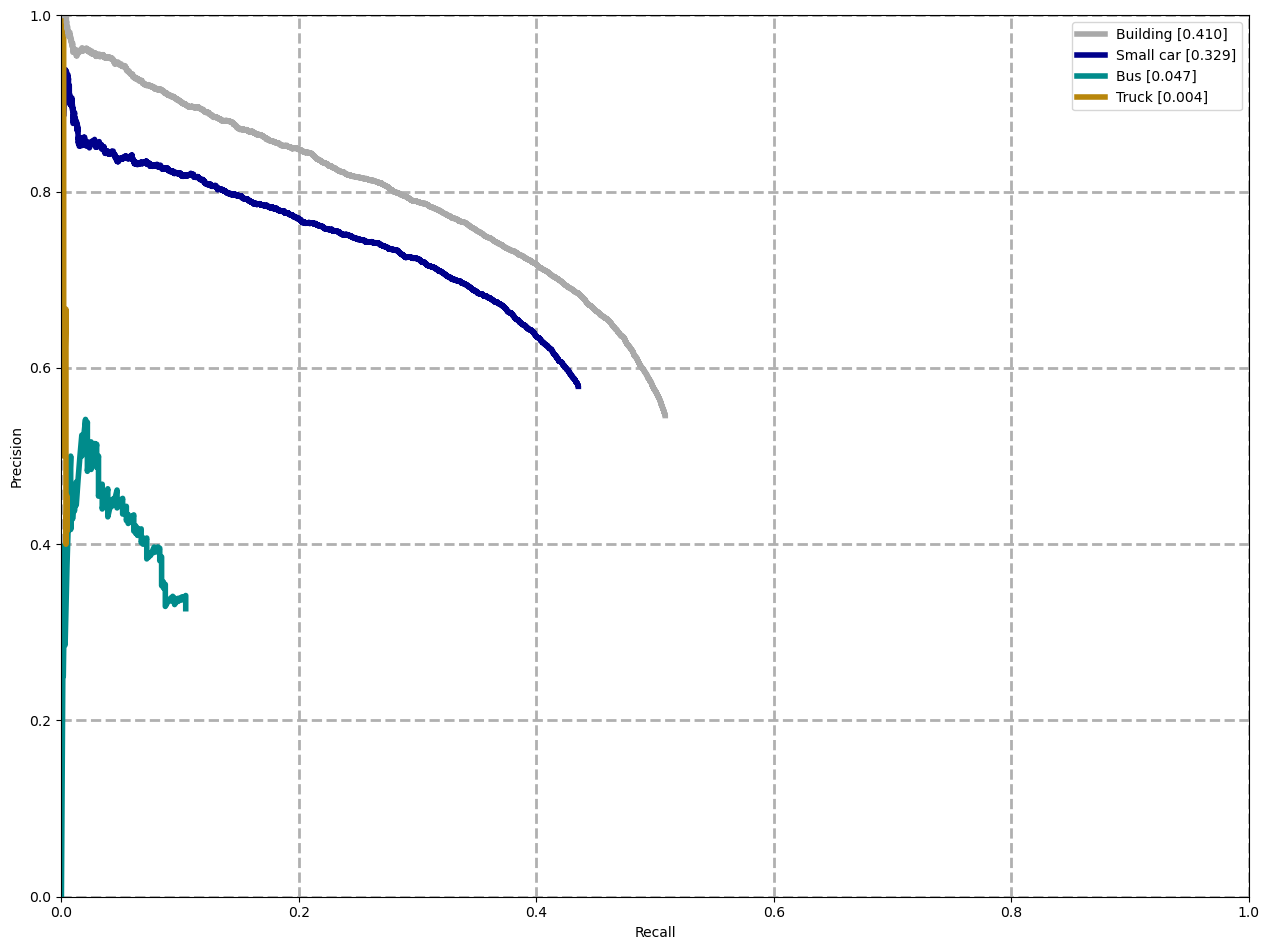

In [18]:
names = list(categories.values()).copy()
names.insert(0, default_cls)
cm = confusion_matrix(y_true, y_pred, labels=names)
print('Confusion matrix:')
print(cm)
draw_confusion_matrix(cm, names)
draw_precision_recall(precision_list, recall_list, categories)

#### Testing
Try to improve the results provided in the competition.

In [19]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('../PROJECT/xview_detection/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[27:] + '/' + filename)
        image.tile = np.array([0, 0, 640, 640])
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 852


In [20]:
import numpy as np
from tqdm import tqdm

model.load_weights('model.keras')
# Generate the list of objects from annotations
filenames_test, tiles_test, bboxes_test, categories_test = zip(*list(map(lambda img_ann: (img_ann.filename, list(img_ann.tile), list([list(obj_ann.bb) for obj_ann in img_ann.objects]), list([list(categories.keys())[list(categories.values()).index(obj_ann.category)] for obj_ann in img_ann.objects])), anns)))
ds_test = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_test, tf.string), tf.cast(tiles_test, tf.int32), tf.cast(tf.ragged.constant(bboxes_test), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_test), tf.float32).to_tensor()))
ds_test = ds_test.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE).cache()
ds_test = ds_test.batch(batch_size=1)
ds_test = ds_test.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# Process each tile sequentially
iterator = iter(ds_test)
predictions = {}
for ann in tqdm(anns):
    # Generate prediction
    image, _ = next(iterator)
    y_pred = model.predict(image, verbose=0)
    predictions.setdefault(ann.filename, {})
    for i in range(np.squeeze(y_pred['num_detections'])):
        obj = GenericObject()
        bbox = np.squeeze(y_pred['boxes'])[i]
        obj.bb = (bbox[0], bbox[1], bbox[2], bbox[3])
        obj.category = categories[np.squeeze(y_pred['classes'])[i]]
        obj.score = np.squeeze(y_pred['confidence'])[i]
        predictions[ann.filename].setdefault(obj.category, {'bbox': [], 'confidence': []})
        predictions[ann.filename][obj.category]['bbox'].append(obj.bb)
        predictions[ann.filename][obj.category]['confidence'].append(obj.score)  # sort detections by confidence
# Save prediction
predictions_data = {"images": {}, "annotations": {}, "categories": {}}
predictions_data["categories"] = categories
imgs_idx, annos_idx = 0, 0
for pred in predictions:
    num_objects = 0
    for cat in predictions[pred]:
        for bb in predictions[pred][cat]['bbox']:
            num_objects += len(predictions[pred][cat]['bbox'])
    image_data = {"image_id": pred.split('/')[-1], "filename": pred, "num_objects": num_objects, "width": 640, "height": 640}
    predictions_data["images"][imgs_idx] = image_data
    imgs_idx += 1
    bboxes, confs = [], []
    for cat in predictions[pred]:
        for i in range(len(predictions[pred][cat]['bbox'])):  
            bbox = predictions[pred][cat]['bbox'][i]
            conf = predictions[pred][cat]['confidence'][i]
            annotation_data = {"image_id": pred.split('/')[-1], "category_id": cat, "bbox": (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])), "confidence": str(conf)}
            predictions_data["annotations"][annos_idx] = annotation_data
            annos_idx += 1

/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/x467/x467548/.local/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
100%|██████████| 852/852 [01:27<00:00,  9.72it/s]


In [21]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)